# Non-parametric regression 

We consider a regession model $Y=h(X)+E$ where $(X,Y)$ are the observations, $E$ is a gaussian noise and $h$ is the function we want to learn. We assume that $h$ is a continuous function such that $h(0)=0$ and that the support of the distribution of $X$ is included in $[0,1]$. 

We set $L(h)$ as the squared loss associated to the model (i.e $L(h) = \mathbb{E}(Y-h(X))^2$ ).

We can thus compute the Malliavin Gradient of $L$ with respect to $h$ as: $$\nabla L (h) (.) = \mathbb{E}\Biggl[ 2(Y-h(X)) \min(.,X) \Biggr] .$$

Theoretically, we have now all the tools to perform a simple stochastic gradient descent to learn $h$. The SGD update takes the form: 
$$ h(.) = h(.) - 2 \alpha (Y-h(X)) \min(.,X)$$ 
where $\alpha$ is the stepsize. However, to implement this method, one has to discretize the interval $[0,1]$. So one may not be able to compute $h(X)$, unless the value of $X$ falls in the discretized interval. 

To avoid this problem, a first approach is to discretize the interval $[0,1]$ beforehand into $d$ and then choose the closest point to each value of $X$ in order to compute $h(X)$. A second approach is to use the sample $X$ itself to discretize $[0,1]$. Surely a compromise between these two approaches must be made with respect to the values of $d$ and $n$. 

Anyhow, we used here the squared loss which gradient can be easily computed. However, for general losses, one can imagine a gradient that is not explicitly known or too coslty to be computed. In this case, referring to Malliavin Calculus, one can compute an unbiased estimate of the gradient using only the loss itself: 
$$ \hat{\nabla L} (h) (.) = \frac{1}{\gamma} L(h(X)+ \gamma B_X) B(.) $$
where $\gamma$ is a smoothing parameter.

Therefore, we can now perform the gradient-free SGD:
$$h(.) = h(.) -  \frac{\alpha}{\gamma} L(h(X)+ \gamma B_X) B(.) $$

Computationally speaking, the same problem as before arises. Moreover, the tuning of the smoothing parameter $\gamma$ is crucial as the gradient-free descent can easily encounter infinite values. 

In [1]:
from matplotlib import pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import sqrtm
from tqdm import tqdm
from math import *
from sklearn import neighbors

AttributeError: module 'matplotlib' has no attribute 'get_data_path'

## 0. A Brownian Motion function 

In [6]:
def brownian(T, N): #returns an array N x trials, each column is a Brownian motion on [0,T]
    #T : Total time.
    #N : Total points
    #trials
    dt = T / N  
    x = np.zeros(N)
    for i in range(N - 1):
        x[i + 1] = x[i] + sqrt(dt) * np.random.randn()
    return x

## V. Black-Scholes 

In [19]:
import scipy
from scipy import stats
import numpy as np

cdf = stats.norm(0, 1).cdf


def d1(S, K, T, r, sigma):
    return (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


def d2(S, K, T, r, sigma):
    return d1(S, K, T, r, sigma) - sigma * np.sqrt(T)



def call(S, K, T, r, sigma):
    return S * cdf(d1(S, K, T, r, sigma)) - K * np.exp(-r * T) * cdf(d2(S, K, T, r, sigma))

S = 100
TT = 1
K = 100
r = 0.05
Sigma = 10
a = call(S, K, TT, r, 0.2*Sigma)
b = call(S, K, TT, r, 0.8*Sigma)
def payoff(sigma):
    #if sigma < 0.2:
    #    return (a/0.2)*(sigma)
    #if sigma > 0.8:
    #    return b
    #else:
    return call(S,K,TT,r,sigma*Sigma)





<ipython-input-19-87d63e5d87ac>:9: RuntimeWarning: divide by zero encountered in true_divide
  return (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


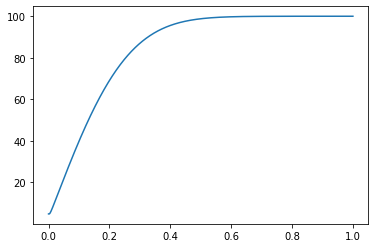

In [20]:
t=np.linspace(0,1,1000)
plt.plot(t, payoff(t) )

In [21]:
def f0(sigma):
        return sigma

In [28]:
#Sample:
n = 1000 #sample size
X = np.random.triangular(0, 0.3, 1, size=n)
E = np.random.normal(0, 10, n)
Y = payoff(X) + E
step = 0.05

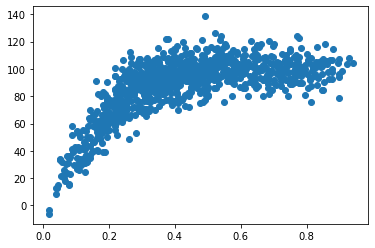

In [29]:
plt.scatter(X,Y)

In [30]:
F = np.zeros((n,n))
for j in range(n):
    F[0,j] = f0(X[j])
F2 = np.zeros((n,n))
B = brownian(1,10000)
indexB = np.zeros(n)
for i in range(n):
    for j in range(n):
        F[i,j] = F[i-1,j] -2*step*(F[i-1,i-1] - Y[i-1])*min(X[i-1],X[j])

In [31]:
d = 1000
t = np.linspace(0,1,1000)
L = np.zeros(d)
for i in range(d):
    Sum = [2*step*(F[j,j]-Y[j])*min(X[j],t[i]) for j in range(n)]
    Sum = sum(Sum)
    L[i] = f0(t[i]) - Sum

<ipython-input-19-87d63e5d87ac>:9: RuntimeWarning: divide by zero encountered in true_divide
  return (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
<ipython-input-19-87d63e5d87ac>:9: RuntimeWarning: divide by zero encountered in true_divide
  return (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


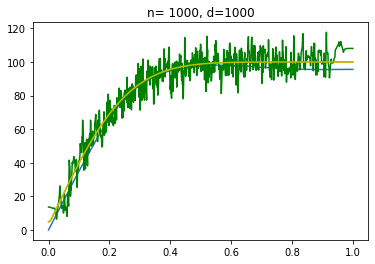

In [32]:
plt.plot(t,L)
X = np.sort( np.random.triangular(0, 0.3, 1, size=(n,1)), axis=0)
T = np.linspace(0, 1, d)[:, np.newaxis]
y = payoff(X)
y = y.ravel()

# Add noise to targets
y += 1 * np.random.normal(0, 10, n)

n_neighbors = 5

weights ='distance'
knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
y_ = knn.fit(X, y).predict(T)

#Visual-------------------------------------------------------------
plt.title("n= "+str(n)+", d=1000")

plt.plot(T, y_, label='NNS', color='g')
plt.plot(T, payoff(T), color='y', label='y=payoff(x)')
                                                         

<ipython-input-25-87d63e5d87ac>:9: RuntimeWarning: divide by zero encountered in true_divide
  return (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


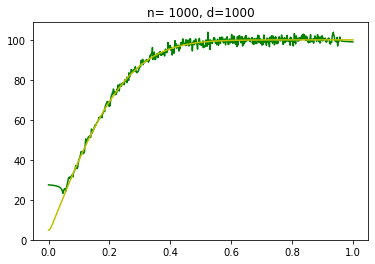

In [118]:
X = np.sort( np.random.triangular(0, 0.7, 1, size=(n,1)), axis=0)
T = np.linspace(0, 1, d)[:, np.newaxis]
y = payoff(X)
y = y.ravel()

# Add noise to targets
y += 1 * np.random.normal(0, 2, n)

n_neighbors = 5

weights ='distance'
knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
y_ = knn.fit(X, y).predict(T)

#Visual-------------------------------------------------------------
plt.title("n= "+str(n)+", d=1000")

plt.plot(T, y_, label='NNS', color='g')
plt.plot(T, payoff(T), color='y', label='y=payoff(x)')
                                                            